<h1>Wasserstein-GAN (WGAN)</h1>

Unterschiede und Vorteile

Es gibt interessante Artikel die das Thema näherbringen und erläutern.

>Ein sehr interessanter Artikel mit vielen Details zur Funktionsweise von WGAN <br>
> Enhancing Generative Modeling: A Comprehensive Analysis of Wasserstein GAN (WGAN): <br>
> https://medium.com/aimonks/enhancing-generative-modeling-a-comprehensive-analysis-of-wasserstein-gan-wgan-81b4c4a5f333 [Letzter Zugriff: 26.07.2024]

> Demystified: Wasserstein GAN with Gradient Penalty(WGAN-GP): <br> 
> https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead [Letzter Zugriff: 26.07.2024]

> WGAN-gp (keras) <br>
> https://www.kaggle.com/code/amanooo/wgan-gp-keras [Letzter Zugriff: 26.07.2024]

<h1>Aufgabe und Dataset</h1>

Die Aufgabe ist mit einem GAN Netzwerk menschliche Gesichter zu generieren. 

In [15]:
# Imports.
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL

Dataset:
> CelebFaces Attributes (CelebA) Dataset:  Over 200k images of celebrities with 40 binary attribute annotations <br>
> https://www.kaggle.com/datasets/jessicali9530/celeba-dataset  [Letzter Zugriff: 26.07.2024]

In [19]:
url = "./data/datasets/faces/img_align_celeba/img_align_celeba"
image_names = os.listdir(url)
len(image_names)

202599

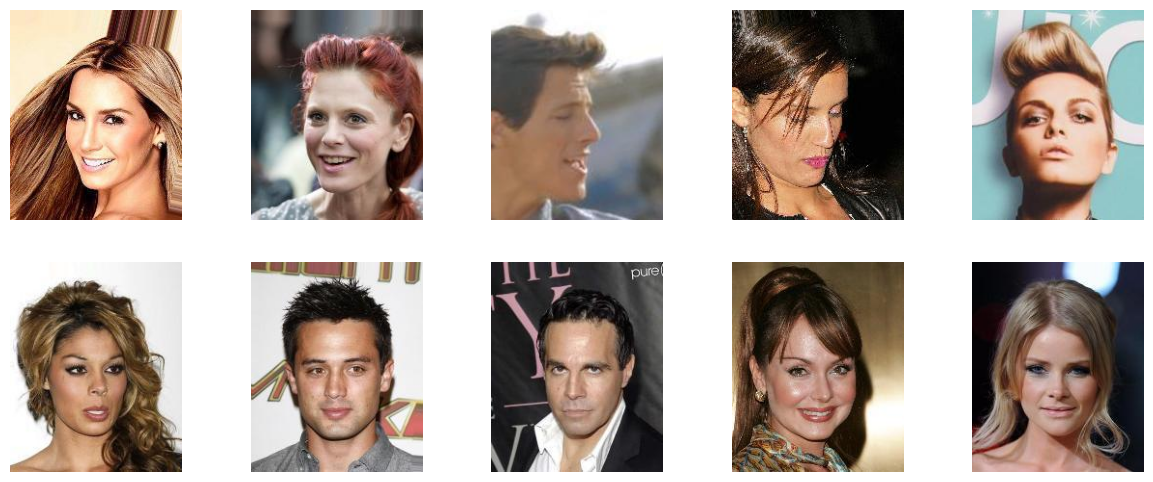

In [36]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()

for i, index in enumerate(np.random.randint(0, len(image_names)-1, 10)):
    img = PIL.Image.open(url+'/'+image_names[i])
    axs[i].set_axis_off()
    axs[i].imshow(img)

Bevor es losgeht, müssen die Bilder skaliert werden.

In [40]:
# Zeige Größer der Bilder.
# - Ggf. kann Größe geändert werden.
img = PIL.Image.open(url+'/'+image_names[5])
np.array(img).shape

(218, 178, 3)

In [ ]:
diff = (np.array(img).shape[0] - np.array(img).shape[1]) // 2
crop_rect = (0, diff, np.array(img).shape[0], np.array(img).shape[1] - diff)

pic = Image.open(url+'/'+image_names[5]).crop(crop_rect)
pic.thumbnail((128, 128), PIL.Image.ANTIALIAS)
pic

In [ ]:
def load_img(img):
    pass

def resize_image(img):
    img = 

def scale_img(img):
    

In [42]:
# Erstelle Dataset. # 
numpy_data = [np.array(PIL.Image.open(url+'/'+name))
              for name in image_names]
assert(len(numpy_data) == len(image_names))
tf_face_dataset = tf.data.Dataset.from_tensor_slices(numpy_data) 
tf_face_dataset

KeyboardInterrupt: 